In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import pandas as pd
import csv
from scipy import stats

In [3]:
from IPython.display import display, HTML
CSS = """.output {align-items: center;}"""
HTML('<style>{}</style>'.format(CSS))

# Déclaration des variables :

In [5]:
xmin=0
xmax=0.14
ymin=0
ymax=250
nbreaks=200

tmax=1000
ncells=1475

lambd=0.1 # paramètre de la loi de Poisson
Nt=0 # nombre de mutations avant le temps t

wt_sim=[] # Wt[x]: fitness simulée au temps t en x
wt_real=[] # Wt[x]: fitness mesurée au temps t en x 

seuil_detection_fitness=0.005

# Tirages au sort :

In [6]:
def tire_exp(lambd): # inutile pour l'instant
    u=np.random.rand()
    res=-1/lambd*np.log(1-u)
    return res

def calcul_Nt(t,lambd): # inutile pour l'instant
    s=0
    res=0
    while(s<t):
        e=tire_exp(lambd)
        s=s+e
        res=res+1
    return res

def mut_occured(lambd): # inutile pour l'instant
    x=np.random.rand()
    res=x<0.4
    return 1#res

def tire_s(s): # tire au sort un effet
    i=np.random.randint(len(s))
    return s[i]

def tire_w(wt_cur): # tire au sort une fitness initiale
    i=np.random.randint(len(wt_cur))
    return wt_cur[i]

# Simulation :

In [7]:
#def exp_sim_canal(tmax): # simule un unique canal
#    w=tire_w(wt_real[2])
#    w_evo=[w]
#    #ngen=0
#    for t in range(tmax):
#        if(mut_occured(lambd)):
#            si=tire_s(s)
#            #if(si!=0):ngen+=1
#            w*=1-si
#        w_evo+=[w]
#    #print(ngen)
#    return w_evo
#
#def exp_sim(tmax,ncells): # simule tous les canaux
#    wt_sim=[]
#    wt_sim_transp=[]
#    for i in range(ncells):
#        w_evo=exp_sim_canal(tmax)
#        wt_sim_transp+=[w_evo]
#    # on transpose pour obtenir une matrice de la bonne forme:
#    for i in range(tmax):
#        wt_cur=[]
#        for j in range(ncells):
#            wt_cur+=[wt_sim_transp[j][i]]
#        wt_sim+=[np.sort(wt_cur)]
#    return wt_sim


def exp_sim_step(wt_cur,s): # simule une étape sur tous les canaux
    wt_nouv=[]
    for w in wt_cur:
        si=tire_s(s)
        wt_nouv+=[w*(1-si)]
    return wt_nouv

# Analyse des données

def get_y(x,wt_cur,eps): # trouve la hauteur de la barre de l'histogramme correspondant à [x-eps/2,x+eps/2]
    y=[]
    i=0
    j=0
    for x_cur in x:
        while x_cur-wt_cur[i]>eps/2 and i<len(wt_cur)-1: i+=1
        while wt_cur[j]-x_cur<eps/2 and j<len(wt_cur)-1: j+=1
        y+=[j-i]
    return y

def get_dist_s(wt_real): # calcul de tous les effets entre chaque mesure (inclut les non-effets en cas de non-division)
    s=[]
    for i in range(2,len(wt_real)-1):
        for j in range(len(wt_real[i])): 
            wv=(wt_real[i])[j]
            wn=(wt_real[i+1])[j]
            if wv!=0:
                s+=[(wv-wn)/wv]
    return s

def sort_rows(w): # pour optimiser la construction de l'histogramme
    res=[]
    for row in w:
        res+=[np.sort(row)]
    return res

# Ouverture du fichier :

In [8]:
def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[0] # attention, pb à régler un jour!
    return res

def analyse_fichier(): # ressort [W_t pour tout t] pour le fichier lu
    wt_tot=[]
    wt_cur=[]
    with open("/Users/jeje/Documents/Scolaire/M2/Projet_DFE/doi_10/All_data/data_microMA/dataset_microMA_MutH.csv", newline='') as csvfile:
        reader=csv.reader(csvfile,delimiter=';')
        nrow=0
        for row in reader:
            if(nrow>=2):
                wt_cur=analyse_ligne(row)
                wt_tot+=[wt_cur]
            nrow+=1
    return wt_tot

# Affichage

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
line1,line2,=ax.plot([], [], [], [])
line = [line1,line2]
ax.legend(["Processus simulé","Processus observé"])
ax.set(xlabel = "Taux de croissance au temps t", ylabel = "Nombre d'individus")
plt.close()

def init():
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(True)
    return line,

def update(frame): # met à jour l'affichage
    global wt_prec
    x=np.linspace(xmin,xmax,nbreaks)
    wt_sim_cur=exp_sim_step(wt_prec,s)
    y_sim=get_y(x,np.sort(wt_sim_cur),eps=(xmax-xmin)/nbreaks)
    wt_prec=wt_sim_cur
    #y_sim=get_y(x,wt_sim[frame],eps=(xmax-xmin)/nbreaks)
    y_real=get_y(x,np.sort(wt_real[frame]),eps=(xmax-xmin)/nbreaks)
    line1.set_data(x,y_sim)
    line2.set_data(x,y_real)
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,


# Lancement :
wt_real=analyse_fichier()
s=get_dist_s(wt_real)

wt_prec=[tire_w(wt_real[2]) for i in range(ncells)]

ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

In [12]:
HTML(ani.to_html5_video())

# Réécriture Pandas/Numpy

In [27]:
wt_real_df = pd.read_csv("/Users/jeje/Documents/Scolaire/M2/Projet_DFE/doi_10/All_data/data_microMA/dataset_microMA_MutH.csv", 
                      sep = ";", 
                      decimal=",", 
                      usecols=range(2,1476*3+1,3), 
                      skiprows=[1,2])
wt_real_df.iloc[:5, :5]

,growth.rate,growth.rate.1,growth.rate.2,growth.rate.3,growth.rate.4
0,0.03527,0.032026,0.028119,0.029765,NaN
1,0.03527,0.032026,0.028119,0.029765,0.033812
2,0.03247,0.032026,0.026802,0.030567,0.033812
3,0.03247,0.032026,0.026802,0.030567,0.033812
4,0.03247,0.033672,0.026802,0.030567,0.033812


In [52]:
np.shape(s)

(1153306,)

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


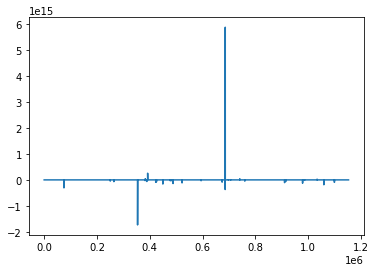

In [51]:
def get_dist_s_np(wt_real_array): # calcul de tous les effets entre chaque mesure (inclut les non-effets en cas de non-division)
    s=-np.diff(wt_real_array)/wt_real_array[:,:-1]
    return s[np.isfinite(s)]

#wt_real_array = np.transpose(np.array(wt_real))
wt_real_array = wt_real_df.T.to_numpy()
s = get_dist_s_np(wt_real_array)

plt.plot(s)
plt.show()